In [72]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.optimize import minimize

T = ['AAPL','NVDA','MSFT','GOOGL','AMZN','META','TSLA','AVGO','BRK/B','LLY']; P=52
full = pd.read_excel("spx_returns_weekly.xlsx","s&p500 rets").rename(columns={'BRK.B':'BRK/B','BRK-B':'BRK/B'})
bench = pd.read_excel("spx_returns_weekly.xlsx","benchmark rets")
full['date'] = pd.to_datetime(full['date']); bench['date']=pd.to_datetime(bench['date'])
df = full[['date']+T].merge(bench[['date','SPY']],on='date').set_index('date').apply(pd.to_numeric,errors='coerce').dropna()



In [73]:
cov = df.cov() * 52
cov.to_numpy()
mean = df.mean() * 52
mean.to_numpy()
TARGET_MEAN = 0.2

In [51]:
def objective(w):        
    return (w.T @ cov @ w)

def fun_constraint_capital(w):
    return np.sum(w) - 1


def fun_constraint_mean(w):
    return (mean @ w) - TARGET_MEAN

In [74]:
constraint_capital = {'type': 'eq', 'fun': fun_constraint_capital}
constraint_mean = {'type': 'eq', 'fun': fun_constraint_mean}
bounds = [[-0.2, 0.35]] * len(mean)
constraints = ([constraint_capital, constraint_mean])

weights = np.ones(len(mean)) / len(mean)
results = minimize(objective, weights, constraints=constraints, bounds = bounds)
weights = pd.Series(results.x, index=mean.index)
print("Contrained Weights")
display(weights)
print("Porttfolio Mean")
mu = weights @ mean
display(mu)
print("Portfolio Volatlity")
sig = np.sqrt(weights @ cov @ weights)
display(sig)
display("Portfolio Sharpe")
sharpe = mu/sig
display(sharpe)

Contrained Weights


AAPL     0.029241
NVDA    -0.014344
MSFT     0.144508
GOOGL    0.009064
AMZN     0.093858
META     0.002874
TSLA    -0.015071
AVGO     0.036250
BRK/B    0.350000
LLY      0.213085
SPY      0.150535
dtype: float64

Porttfolio Mean


0.199999999998153

Portfolio Volatlity


0.16488914935836244

'Portfolio Sharpe'

1.2129360893449832

In [75]:
vol = np.sqrt(df.var() * 52)
asset_sharpe = mean / vol
print("Asset Sharpes")
display()
print("Asset Means")
display(mean)
print("Contrained Weights")
display(weights)

Asset Sharpes
Asset Means


AAPL     0.238714
NVDA     0.645580
MSFT     0.261402
GOOGL    0.216800
AMZN     0.293447
META     0.261924
TSLA     0.469754
AVGO     0.394854
BRK/B    0.135025
LLY      0.281542
SPY      0.131264
dtype: float64

Contrained Weights


AAPL     0.029241
NVDA    -0.014344
MSFT     0.144508
GOOGL    0.009064
AMZN     0.093858
META     0.002874
TSLA    -0.015071
AVGO     0.036250
BRK/B    0.350000
LLY      0.213085
SPY      0.150535
dtype: float64

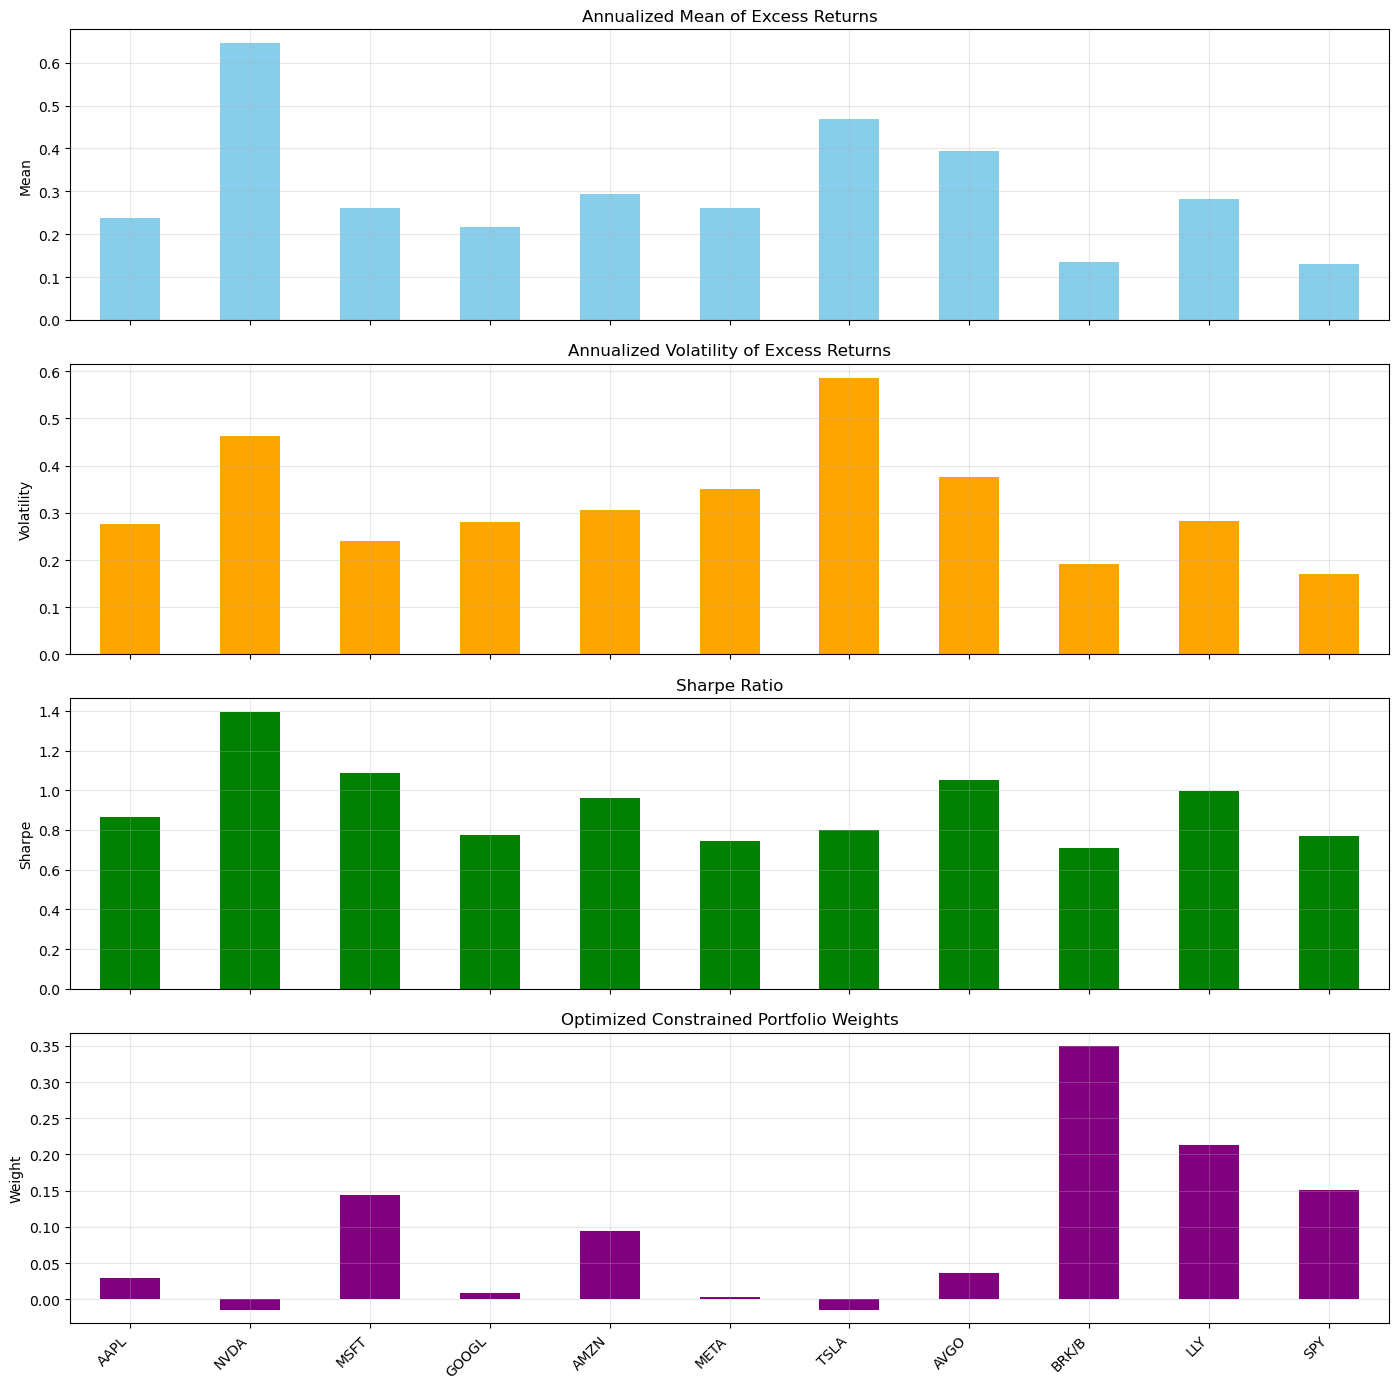

In [77]:
import matplotlib.pyplot as plt
import pandas as pd


summary = pd.DataFrame({
    "Annual Mean": mean,
    "Annual Volatility": vol,
    "Sharpe Ratio": asset_sharpe,
    "Constrained Weight": weights
})


fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)


summary["Annual Mean"].plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Annualized Mean of Excess Returns")
axes[0].set_ylabel("Mean")


summary["Annual Volatility"].plot(kind="bar", ax=axes[1], color="orange")
axes[1].set_title("Annualized Volatility of Excess Returns")
axes[1].set_ylabel("Volatility")


summary["Sharpe Ratio"].plot(kind="bar", ax=axes[2], color="green")
axes[2].set_title("Sharpe Ratio")
axes[2].set_ylabel("Sharpe")


summary["Constrained Weight"].plot(kind="bar", ax=axes[3], color="purple")
axes[3].set_title("Optimized Constrained Portfolio Weights")
axes[3].set_ylabel("Weight")


for ax in axes:
    ax.grid(alpha=0.3)
    ax.set_xlabel("")  

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
